# Classification of Stellar Objects

**Authors:** Margarita Kapustina, Linda Chu, Muhammad Shahbaz Murtaza, Brendan Yuen

### Introduction

In astronomy, the classification of stars, galaxies, and quasars is fundamental towards the understanding of our own galaxy. Galaxies are large systems of stars (Greshko, 2021), whereas quasars are active galactic nuclei powered by supermassive black holes found at the center of massive galaxies (Bañados et al. 2016). The three can be hard to differentiate solely through observation as they all radiate different wavelengths, hence, astronomers use other spectral characteristics for object identification.

This project aims to answer the following predictive question: Is it possible to use Sloan Digital Sky Survey (SDSS) measurements to predict whether a future stellar body of an unknown type is a star, quasar or galaxy?

The dataset used in our project contains 100,000 observations of space, each of which are classified as a star, galaxy, or quasar, based on their spectral characteristics. Every observation was taken by the SDSS and was given a unique object identifier.

_Dataset of interest: 2017 Stellar Classification (SDSS17)_ https://www.kaggle.com/datasets/fedesoriano/stellar-classification-dataset-sdss17

The original dataset contained 17 variables, of which 7 we are interested in. The variables of interest we will use in our project include:

- **u**: the ultraviolet filter in the photometric system
- **g**: the green filter in the photometric system
- **r**: the red filter in the photometric system
- **i**: the near infrared filter in the photometric system
- **z**: the infrared filter in the photometric system
- **class**: the object class (galaxy, star, or quasar object)
- **redshift**: the redshift value based on the increase in wavelength

The **class** variable is the categorical variable to be predicted. As for the characteristics of the observed objects, **photometrics** measure the intensities of different wavelengths and are used to study the structure and composition of celestial objects (Grier & Rivkin, 2019), whereas **redshift** is used to study the distance, velocity, and other calculations. Thus, we chose these variables as potential predictors. Recently, redshifts have been described as an essential tool of observational astronomy and cosmology (Benitez, 2000). In simpler terms, redshift is used to measure how the universe expands, and allows us to determine the distance to the universe’s oldest and most distant objects (Giovanelli et al., 1991).

The redshift measure itself is the shift of spectrum of an astronomical object towards red (ie. longer) wavelengths (Britannica, 2023). An alternate view on the source of cosmological redshift, states that it may be the result of a loss of energy which light incurs in the great lengths of space it traverses from distant star systems (Assis & Nevis, 1995). 

As redshift aids in determining other significant attributes of objects in astronomy, such as the distance between galaxies and star formation rate (Sandeep et al., 2021), redshift may help classify SDSS observations as types of stellar bodies and is therefore important for our predictive model. Additionally, recent classifiers trained to predict galaxies of different classes have also incorporated redshift measures into their training model, such as Sandeep et al.’s 2021 study. Thus, we expect that it will help predict the type of stellar body in our model.


### Methods

The variables we use to classify the type of a new SDSS observation include all the photometric measurements (originally labeled **u, g, r, i,** and **z**) and the **redshift**. Previous literature and classification models have demonstrated that many of these factors correlate with stellar body types and may contribute to classifying an astronomical event of type galaxy, quasar or star (Finlay-Freundlich, 1954; Wierzbiński et al. 2021; Simet et al. 2021). 

In our analysis, we use the k-nearest neighbors algorithm, or KNN. As the class labels are already known and the predictive question is a classification problem, KNN fits the purpose for this project. The KNN algorithm requires the original data set to be split into two subsets: the training set and the testing set. Once the training set has completed its preprocessing and the classification model is ready, the testing set is used to evaluate the accuracy of the classification model. 

We started by loading the packages necessary for our analysis into R.

In [7]:
library(tidyverse)
library(repr)
library(tidymodels)
library(cowplot)
options(repr.matrix.max.rows = 6)

#### Loading and Wrangling the Data

To load our dataset of interest, we used the **read_csv** function to read the dataset, which was in a **.csv** text file format, and assigned it to an object called **star_data**. Then we verified whether any columns were missing information by counting the number of cells with missing values in each column.

In [33]:
star_data <- read_csv("https://raw.githubusercontent.com/Margokap/DSCI100-group-03/main/star_classification.csv")

invisible(map_df(star_data, ~sum(is.na(.))))

Rows: 100000 Columns: 18
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (1): class
dbl (17): obj_ID, alpha, delta, u, g, r, i, z, run_ID, rerun_ID, cam_col, fi...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


None of the cells were missing information. Since we are only interested in the photometric variables, the redshift, and the class, we kept only these columns using the **select** function and assigned it to an object called **star_data_tidy**.

In [34]:
star_data_tidy <- select(star_data, u, g, r, i, z, redshift, class)

"Table 1.0 Stellar Data of Interest"
star_data_tidy

[1] "Table 1.0 Stellar Data of Interest"

u,g,r,i,z,redshift,class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
23.87882,22.27530,20.39501,19.16573,18.79371,0.6347936,GALAXY
24.77759,22.83188,22.58444,21.16812,21.61427,0.7791360,GALAXY
25.26307,22.66389,20.60976,19.34857,18.94827,0.6441945,GALAXY
⋮,⋮,⋮,⋮,⋮,⋮,⋮
21.16916,19.26997,18.20428,17.69034,17.35221,0.1433656,GALAXY
25.35039,21.63757,19.91386,19.07254,18.62482,0.4550396,GALAXY
22.62171,21.79745,20.60115,20.00959,19.28075,0.5429442,GALAXY


We changed the column titles to be more comprehensive, which concluded the tidying of the data set.

In [35]:
names(star_data_tidy) <- c("UV_filter",
                            "Green_filter",
                            "Red_filter",
                            "Near_Infrared_filter",
                            "Infrared_filter",
                            "Redshift",
                            "Stellar_object")
star_data_tidy <- star_data_tidy |>
                  mutate(Stellar_object = as.factor(Stellar_object))

#### Exploratory Data Analysis

To understand how our data was distributed across each stellar object, in other words, to compare the proportions of observations belonging to each stellar class, we created a bar graph visualization (see Figure 1.0).

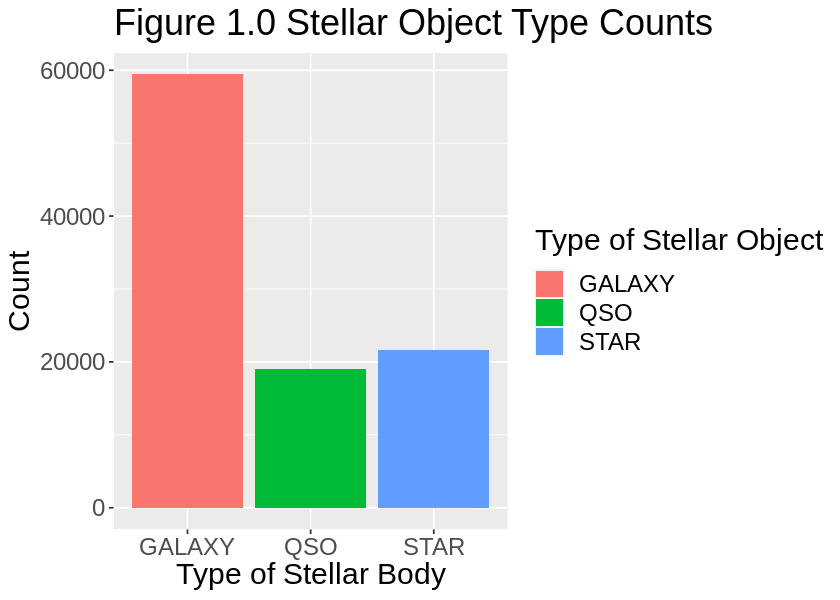

In [37]:
count <- star_data_tidy |> 
         group_by(Stellar_object) |>
         summarize(count = n())

star_counts_plot <- ggplot(count, aes(x = Stellar_object, y = count, fill = Stellar_object)) + 
    geom_bar(stat = "identity") +
    labs(x = "Type of Stellar Body", fill = "Type of Stellar Object", y = "Count") + 
    theme(text = element_text(size = 18)) +
    ggtitle("Figure 1.0 Stellar Object Type Counts") +
    scale_color_brewer(palette = "Set2")

star_counts_plot

The majority class was clearly galaxy, which can be seen by the great difference in height between the galaxy bar and the other two classes. To counter this imbalance, we sampled 1000 observations of each type of stellar object, bound the samples together, and sampled 1000 observations of the bound samples.

In [38]:
set.seed(999)
#sampling from data to make data balanced
star_data_star <- star_data_tidy |>
                  filter(Stellar_object == "STAR") |>
                  sample_n(1000)

star_data_galaxy <- star_data_tidy |>
                  filter(Stellar_object == "GALAXY") |>
                  sample_n(1000)

star_data_qso <- star_data_tidy |>
                  filter(Stellar_object == "QSO") |>
                  sample_n(1000)

star_data_balanced <- rbind(star_data_qso, star_data_galaxy, star_data_star) |>
                  sample_n(1000)

star_table <- star_data_balanced |>
              group_by(Stellar_object) |>
              summarize(Counts = n())

"Table 1.1 Object Count per Stellar Type"
star_table

[1] "Table 1.1 Object Count per Stellar Type"

Stellar_object,Counts
<fct>,<int>
GALAXY,347
QSO,331
STAR,322


The resulting data set is much more balanced. 

We then split our balanced and tidied data into two subsets using the **initial_split** function: the training set, called **star_training** and the testing set, called **star_testing**. To prevent any organizational structure of the data from influencing the model, we set the strata parameter to the class variable, Stellar_object. The training set also contains 75% of the balanced data.

In [39]:
star_split <- initial_split(star_data_balanced, prop = 0.75, strata = Stellar_object)
star_training <- training(star_split)
star_testing <- testing(star_split)

Following this, we visualized each of our photometric variables against the redshift. Since there are six predictors, a single visualization would not be an effective method to deepen our understanding of the type and strength of the correlation between the predictors and the stellar classes. Moreover, redshift is the only predictor that is not a photometric, and redshift and photometrics are used to measure different characteristics of stellar objects. Therefore, visualizations between the redshift and photometric variables may be more significant than visualizations between different photometric variables, which all measure intensities of light. As multiple 2D scatterplots is more effective than a single plot with all seven predictors, we created visualizations with each photometric plotted against redshift (see Figures 1.1, 1.2, 1.3, 1.4, and 1.5).

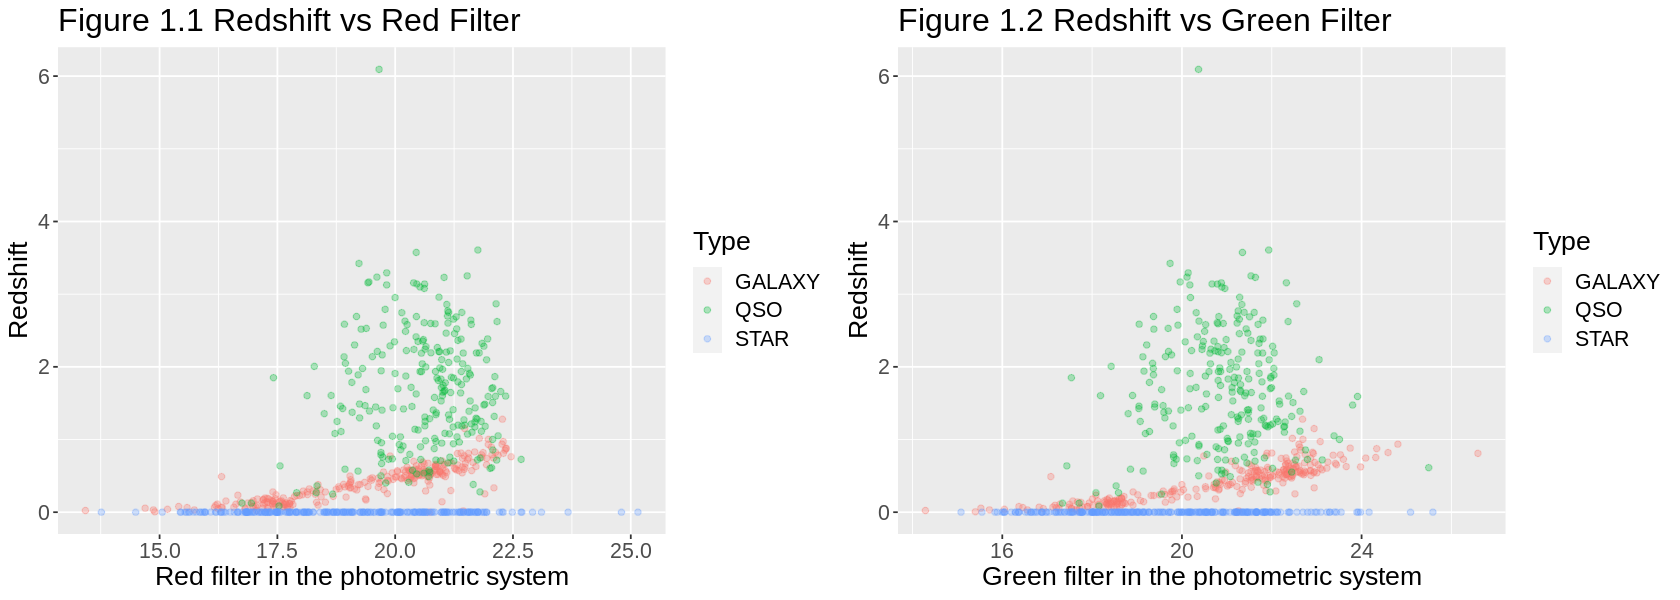

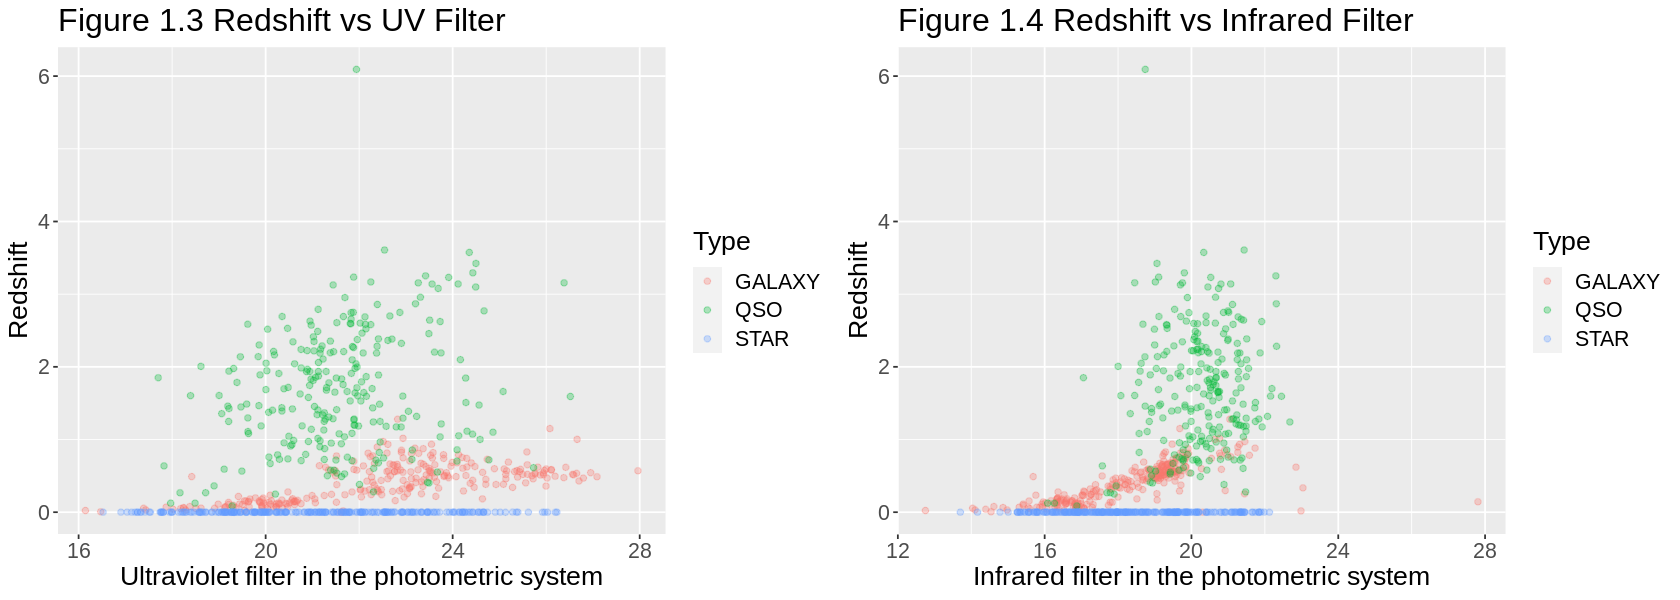

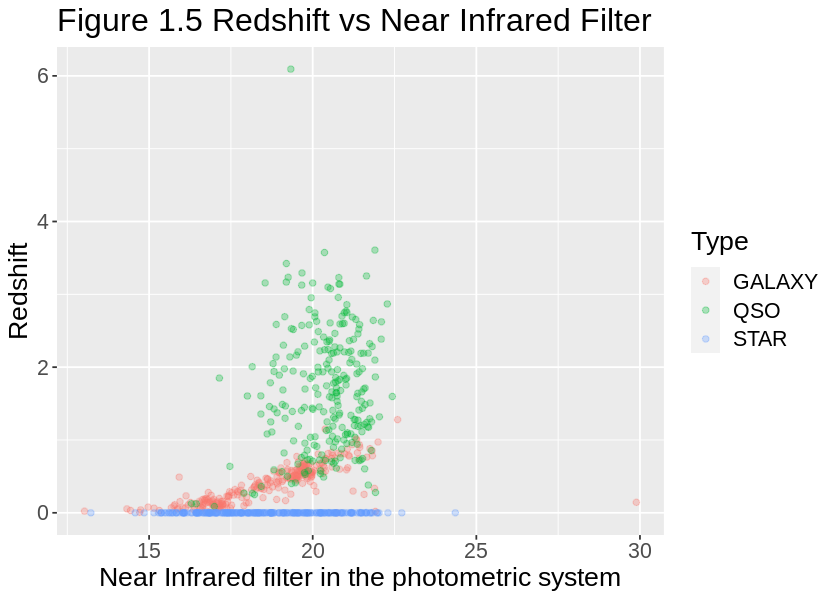

In [40]:
options(repr.plot.height = 5, repr.plot.width = 14)

rs_vs_r <- ggplot(star_training, aes(y = Redshift, x = Red_filter, color = Stellar_object)) +
                              geom_point(alpha = 0.3) +
                              labs(y = "Redshift", x = "Red filter in the photometric system", color = "Type") +
                              theme(text = element_text(size = 16)) +
                              ggtitle("Figure 1.1 Redshift vs Red Filter")

rs_vs_g <- ggplot(star_training, aes(y = Redshift, x = Green_filter, color = Stellar_object)) +
                              geom_point(alpha = 0.3) +
                              labs(y = "Redshift", x = "Green filter in the photometric system", color = "Type") +
                              theme(text = element_text(size = 16)) +
                              ggtitle("Figure 1.2 Redshift vs Green Filter")

rs_vs_uv <- ggplot(star_training, aes(y = Redshift, x = UV_filter, color = Stellar_object)) +
                              geom_point(alpha = 0.3) +
                              labs(y = "Redshift", x = "Ultraviolet filter in the photometric system", color = "Type") +
                              theme(text = element_text(size = 16)) +
                              ggtitle("Figure 1.3 Redshift vs UV Filter")

rs_vs_ir <- ggplot(star_training, aes(y = Redshift, x = Infrared_filter, color = Stellar_object)) +
                              geom_point(alpha = 0.3) +
                              labs(y = "Redshift", x = "Infrared filter in the photometric system", color = "Type") +
                              theme(text = element_text(size = 16)) +
                              ggtitle("Figure 1.4 Redshift vs Infrared Filter")

rs_vs_nir <- ggplot(star_training, aes(y = Redshift, x = Near_Infrared_filter, color = Stellar_object)) +
                              geom_point(alpha = 0.3) +
                              labs(y = "Redshift", x = "Near Infrared filter in the photometric system", color = "Type") +
                              theme(text = element_text(size = 16)) +
                              ggtitle("Figure 1.5 Redshift vs Near Infrared Filter")

plot_grid(rs_vs_r, rs_vs_g)
plot_grid(rs_vs_uv, rs_vs_ir)

options(repr.plot.height = 5, repr.plot.width = 14/2)
rs_vs_nir


The figures are each very similar to one another. This further reinforces the decision to use all photometrics and the redshift as predictors in the model, as no specific photometric is substantially more valuable than the others.

#### Performing the Data Analysis

To perform the data analysis, we first trained and fitted our model on the training data. We created a recipe with all variables of interest but the class variable as our predictors. To prevent any predictor from having more impact on the model than the others, we scaled and centered all predictors.

In [41]:
stellar_recipe <- recipe(Stellar_object ~. , data = star_training) |>
   step_scale(all_predictors()) |>
   step_center(all_predictors())

For our classification model, we are using k-nearest neighbours. Hence, we created a spec with the kknn engine and set the mode to classification. As we did not yet know which k-value was optimal, we set the neighbours to tune().

In [42]:
knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
            set_engine("kknn") |>
            set_mode("classification")

To find the optimal k-value, we used the cross-validation method. We used 10 folds and balanced the proportion of observations belonging to each class in each fold using the strata parameter. We decided to test k-values from 1 to 50, a range sufficiently large that would give a better understanding of the optimal k-value.

In [43]:
stellar_vfold <- vfold_cv(star_training, v = 10, strata = Stellar_object)

gridvals <- tibble(neighbors = c(1:50))

To perform the cross-validation method, we used a workflow to fit the recipe and the spec model onto our training data. Since we are only interested in the accuracy of the different k-values, we collected the metrics of the results and assigned the accuracy metric to the object called knn-results.

In [44]:
knn_results <- workflow() |>
      add_recipe(stellar_recipe) |>
      add_model(knn_tune) |>
      tune_grid(resamples = stellar_vfold, grid = gridvals) |>
      collect_metrics() |>
      filter(.metric == "accuracy") |>
      select(neighbors, mean) |>
      arrange(desc(mean))

"Table 1.2 K-Values with Highest Accuracy"
head(knn_results)

[1] "Table 1.2 K-Values with Highest Accuracy"

neighbors,mean
<int>,<dbl>
1,0.8971323
2,0.8971323
4,0.8851669
3,0.8838336
5,0.8811498
6,0.8798165


From the table, it is clear that the k-value 1 has the highest accuracy. To visualize all the k-values and their mean accuracies, we created a line plot (Figure 1.6).

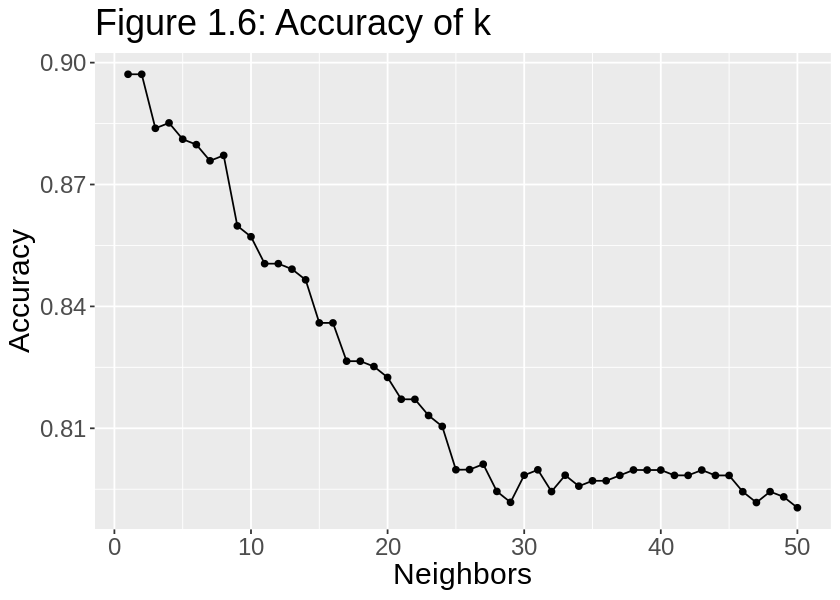

In [45]:
accuracy_line <- ggplot(knn_results, aes(x = neighbors, y = mean))+
      geom_point() +
      geom_line() +
      labs(x = "Neighbors", y = "Accuracy", title = "Figure 1.6: Accuracy of k") +
      theme(text = element_text(size = 18))

accuracy_line

As the k-value with the highest accuracy is 1, the lowest possible value of k, our trained model may have overfitted the data. Thus, we created a new model spec with the neighbors parameter set to 4, which is more reasonable as it had the highest accuracy after k = 1 and k = 2. With the new model spec, a new workflow was established and fit on the training data.

In [46]:
stellar_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 4) |>
    set_engine("kknn") |>
    set_mode("classification")

stellar_fit <- workflow() |>
    add_recipe(stellar_recipe) |>
    add_model(stellar_spec) |>
    fit(data = star_training)

Finally, the classification model was used to predict the stellar classes for the testing data set. To find the accuracy of this model, the metrics were collected and the accuracy metric was selected. Additionally, the confusion matrix was created to show a more detailed overview of the results.

In [47]:
stellar_predict <- predict(stellar_fit, star_testing) |>
               bind_cols(star_testing)

"Table 1.3 Stellar Object Predictive Model Accuracy"
(metrics <- stellar_predict |>
    metrics(truth = Stellar_object, estimate = .pred_class) |>
    filter(.metric == "accuracy"))

"Table 1.4 Stellar Object Predictive Model Confusion Matrix"
(conf_mat <- stellar_predict |>
    conf_mat(truth = Stellar_object, estimate = .pred_class))

[1] "Table 1.3 Stellar Object Predictive Model Accuracy"

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.8844622


[1] "Table 1.4 Stellar Object Predictive Model Confusion Matrix"

          Truth
Prediction GALAXY QSO STAR
    GALAXY     68   4    5
    QSO         8  78    0
    STAR       11   1   76

### Results

This study aimed to discover whether it was possible to use Sloan Digital Sky Survey (SDSS) measurements to predict whether a future stellar body of an unknown type is a star, quasar or galaxy. By creating a k-nearest neighbors classification model with a k-value of 4, this study found that it was indeed possible to predict the future stellar body of an unknown type of star, quasar, or galaxy, to a measured accuracy of 0.88 on a testing data set.

We must also note that although the highest accuracy provided in Figure 1.6 was for the 1 neighbor (k = 1), we designed our model using 4 neighbors (k = 4), due to the high chance of overfitting the data. This outcome may have resulted from potentially underfitting the data, which may have occurred while balancing the dataset. Alternatively, it could also be a consequence of potential clustering in our dataset, which may not have minimized even by stepping and scaling the data. However, we can have some confidence in our results, since the final model with 4 neighbors procured an accuracy of 0.88 when classifying the testing data set, which in layman terms, suggests that our model predicts the type of the stellar object accurately 88 times out of 100.

### Discussion

Our study would be beneficial to both cosmologists and astronomers. Being able to predict the type of stellar body based on a SDSS observation with high accuracy will allow for the efficient characterization of the cosmos. As the universe expands continuously, an accurate representation of the stellar matter in our galaxy will increase our fundamental understanding of the universe and of any changes currently occuring in the cosmos, for instance, potentially stark changes in the quantity of stellar objects of a particular type (ie. star, quasar or galaxy). This study could also serve as an initial base or prototype for more capable, efficient, and higher-dimension classification models which can predict for more than the three stellar bodies. Furthermore, our model can be expanded upon to become capable of determining sub-categories for observations of each class. For instance, when a star is identified, the specialized model could predict the type of star (ex. a red giant). Alternatively, or additionally, such a specialized model could predict where the star would lie on the Hertzsprung-Russell Diagram, which would aid in learning its behaviour, age, and current status (ie. active or dormant). Advanced classification and predictive models such as these may lead to further research and a much deeper understanding than the surface-level categorisation currently performed by our model. But this also begs several questions: Can our model expand its classification ability beyond the observable universe? Could our model be used to identify which stellar object new and previously uncategorised discoveries behave similar to? Such questions could be explored further given extensive research and remodelling. 

To improve the performance accuracy of our classification model, we can collect observations made from multiple telescopes (such as Hubble, James Webb Telescopes etc.), fuse those observations in a larger dataset, which can then be used to train our classification model. This could be helpful in minimizing errors which may exist in our current dataset, that went undetected with our analysis. Additionally, assessing other performance metrics such as precision and recall may increase the confidence in our classification model. We could also employ a predictor selection method (such as forward selection) before training our model, which could better indicate which predictors are most crucial to our classification, that may have been previously neglected. These tactics could prove to be imperative in enhancing and refining our classification model, and help us gain more confidence in ensuring that the model generalizes well to new, unseen data.

**Literature Cited:**

+ Bañados, E.,  Venemans, B. P., Decarli, R., Farina, E. P., Mazzucchelli, C., Walter, F.,  Fan, X.,  Stern, D., Schlafly, E., Chambers, K. C., Rix, H-W.,  Jiang, L., McGreer, I., Simcoe, R., Wang, F., Yang, J., Morganson, E., De Rosa, G., Greiner, J., …Q. Yang. (2016). THE PAN-STARRS1 DISTANT z > 5.6 QUASAR SURVEY: MORE THAN 100 QUASARS WITHIN THE FIRST GYR OF THE UNIVERSE. The American Astronomical Society. 227(1). doi: 10.3847/0067-0049/227/1/11

+ Becker, I., Pichara, K., Catelan, M., Protopapas, P., Aguirre, C., & Nikzat, F. (2020). Scalable end-to-end recurrent neural network for variable star classification. Monthly Notices of the Royal Astronomical Society, 493(2), 2981-2995.

+ Finlay-Freundlich, E. (1954). Red-shifts in the spectra of celestial bodies. Proceedings of the Physical Society. Section A, 67(2), 192.

+ Greshko, M. (2021, May 4). Galaxy Information and facts. Science. Retrieved March 11, 2023, from https://www.nationalgeographic.com/science/article/galaxies 

+ Simet, M., Chartab, N., Lu, Y., & Mobasher, B. (2021). Comparison of observed galaxy properties with semianalytic model predictions using machine learning. The Astrophysical Journal, 908(1), 47.

+ The European Space Agency. (n.d.). What is 'red shift'? ESA. url: https://www.esa.int/Science_Exploration/Space_Science/What_is_red_shift 

+ Grier, A.J, & Rivkin, A.S. (2019). Airless Bodies of the Inner Solar System. Understanding the Process Affecting Rocky, Airless Surfaces. Chapter 4, 47-94

+ Wierzbiński, M., Pławiak, P., Hammad, M., & Acharya, U. R. (2021). Development of accurate classification of heavenly bodies using novel machine learning techniques. Soft Computing, 25(10), 7213-7228.

+ Britannica, T. Editors of Encyclopaedia (2023, February 24). redshift. Encyclopedia Britannica. https://www.britannica.com/science/redshift

+ Benitez, N. (2000). Bayesian photometric redshift estimation. The Astrophysical Journal, 536(2), 571.

+ Giovanelli, R., & Haynes, M. P. (1991). Redshift surveys of galaxies. Annual review of astronomy and astrophysics, 29(1), 499-541.

+ Assis, A. K. T., & Neves, M. C. D. (1995). The redshift revisited. Astrophysics and Space Science, 227, 13-24.

+ Sandeep, V. Y., Sen, S., & Santosh, K. (2021, July). Analyzing and processing of astronomical images using deep learning techniques. In 2021 IEEE International Conference on Electronics, Computing and Communication Technologies (CONECCT) (pp. 01-06). IEEE.

+ Borne, K. (2009). Scientific data mining in astronomy. arXiv preprint arXiv:0911.0505.